In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [121]:
df=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V2.csv")

In [122]:
df.head()

,Energy_Unit_log,Event_freq_unit_per_day_log,Duration_days_log,Energy_per_Volume_log,Energy_density_Joule,Volume_m3,Energy_Joule_per_day,Volume_m3_per_day,Intensity_Level_encoded,Intensity_Level
0,3.737670,1.553291,2.484907,2.275682,5.968,4.694,4.926,3.653,3,Intense
1,2.708050,0.938444,2.302585,1.393516,5.841,4.622,4.887,3.668,2,Moderate
2,2.890372,1.060910,2.302585,1.582328,4.754,4.397,3.800,3.443,2,Moderate
3,2.944439,1.029619,2.397895,1.574296,5.295,4.703,4.295,3.703,2,Moderate
4,2.397895,0.887480,2.079442,1.211823,5.322,4.238,4.477,3.393,2,Moderate


In [123]:
df.describe()

,Energy_Unit_log,Event_freq_unit_per_day_log,Duration_days_log,Energy_per_Volume_log,Energy_density_Joule,Volume_m3,Energy_Joule_per_day,Volume_m3_per_day,Intensity_Level_encoded
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,2.256542,0.858804,2.072434,1.159270,4.537699,4.188721,3.733064,3.368868,1.142857
std,0.780441,0.385526,0.459606,0.542145,1.071878,0.545470,0.954581,0.474191,1.060099
min,1.252763,0.390351,1.386294,0.457454,2.790000,3.375000,2.369500,2.663500,0.000000
25%,1.497866,0.545122,1.609438,0.617543,3.781000,3.718000,2.870500,2.956500,0.000000
50%,2.197225,0.798408,2.079442,1.102460,4.614000,4.238000,3.739000,3.474000,1.000000
75%,2.890372,1.098612,2.397895,1.526582,5.311000,4.643500,4.575000,3.724500,2.000000
max,3.850148,1.743969,2.833213,2.326910,6.391400,5.029400,5.535200,4.186000,3.000000


## Using SMOTE to balance the data

In [124]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data
X = df.drop(columns=['Intensity_Level_encoded','Intensity_Level'])
y = df['Intensity_Level_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

# Applying SMOTE on train set only
smote = SMOTE(random_state=20)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Intensity_Level_encoded
0    27
2    20
1    16
3     9
Name: count, dtype: int64
After SMOTE: Intensity_Level_encoded
1    27
0    27
2    27
3    27
Name: count, dtype: int64


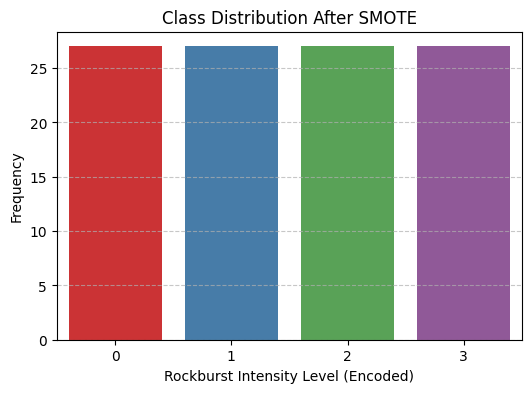

In [125]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="Set1",hue=y_train_res,legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Noise Injection To increase the samples

In [126]:
# Function to add noise
def add_noise(data, noise_factor=0.01):
    noisy_data = data.copy()
    for col in noisy_data.columns:
        if np.issubdtype(noisy_data[col].dtype, np.number):
            std_dev = noisy_data[col].std()
            noise = np.random.normal(0, std_dev * noise_factor, size=noisy_data[col].shape)
            noisy_data[col] = noisy_data[col] + noise
    return noisy_data


In [127]:
target_size = 250
augmented_X = [X_train_res]
augmented_y = [y_train_res]

while len(pd.concat(augmented_X)) < target_size:
    X_noisy = add_noise(X_train_res, noise_factor=0.01)
    augmented_X.append(X_noisy)
    augmented_y.append(y_train_res)  # Labels same rahenge

# --- Step 4: Final Dataset ---
final_X_train = pd.concat(augmented_X).reset_index(drop=True)
final_y_train = pd.concat(augmented_y).reset_index(drop=True)

# Agar size exact 1000 chahiye
final_X_train = final_X_train.iloc[:target_size]
final_y_train = final_y_train.iloc[:target_size]

print("Final Train Size:", len(final_X_train))
print(final_y_train.value_counts())

Final Train Size: 250
Intensity_Level_encoded
0    66
2    64
1    61
3    59
Name: count, dtype: int64


In [128]:
df=pd.concat([final_X_train,final_y_train],axis=1)

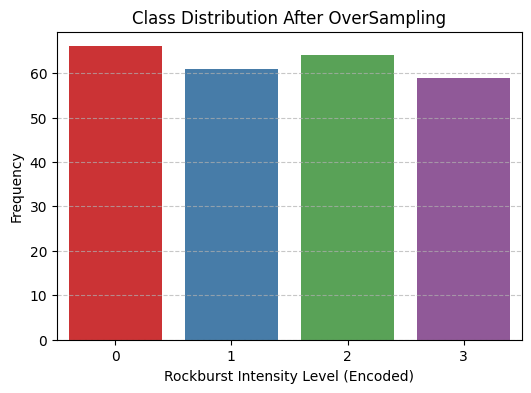

In [129]:
plt.figure(figsize=(6,4))
sns.countplot(x=final_y_train, palette="Set1",hue=final_y_train,legend=False)
plt.title("Class Distribution After OverSampling")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [130]:
df.describe()

,Energy_Unit_log,Event_freq_unit_per_day_log,Duration_days_log,Energy_per_Volume_log,Energy_density_Joule,Volume_m3,Energy_Joule_per_day,Volume_m3_per_day,Intensity_Level_encoded
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,2.421938,0.919698,2.126087,1.262207,4.853807,4.327306,4.020834,3.483859,1.464000
std,0.787050,0.406546,0.449691,0.552278,1.075529,0.540360,0.981789,0.472926,1.119696
min,1.231591,0.380438,1.380215,0.466178,2.780937,3.367149,2.357605,2.651756,0.000000
25%,1.791759,0.572221,1.689756,0.817984,4.161610,3.972934,3.325250,3.144430,0.000000
50%,2.456034,0.888581,2.239284,1.226074,4.948241,4.368969,4.031128,3.553378,1.000000
75%,2.986001,1.177406,2.482430,1.595743,5.720510,4.843443,4.806816,3.809025,2.000000
max,3.860326,1.750067,2.840913,2.326910,6.401910,5.037938,5.554863,4.196480,3.000000


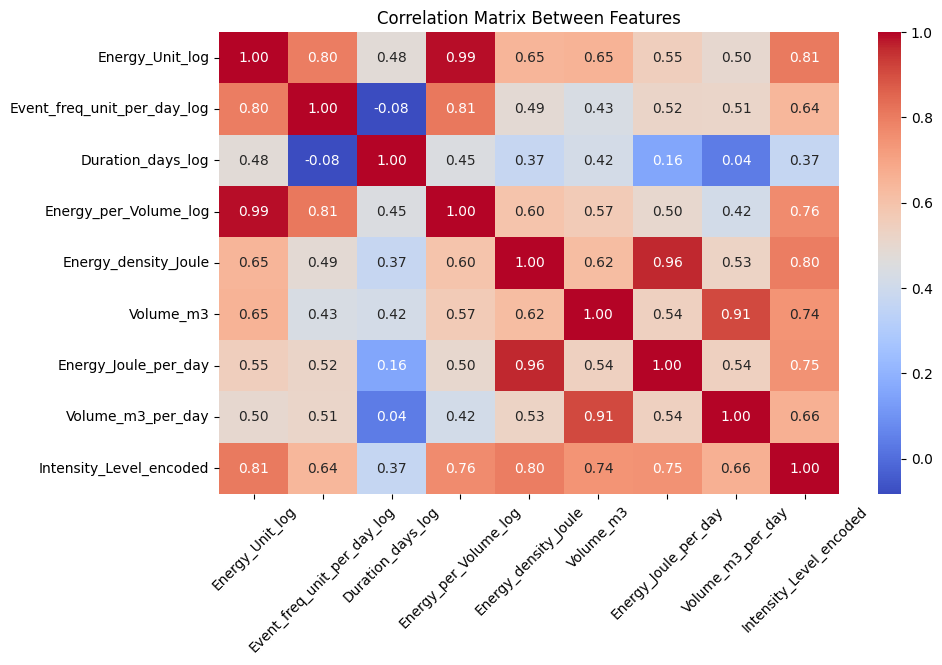

In [131]:
columns=df.columns
plt.figure(figsize=(10,6))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Features")
plt.xticks(rotation=45)
plt.show()


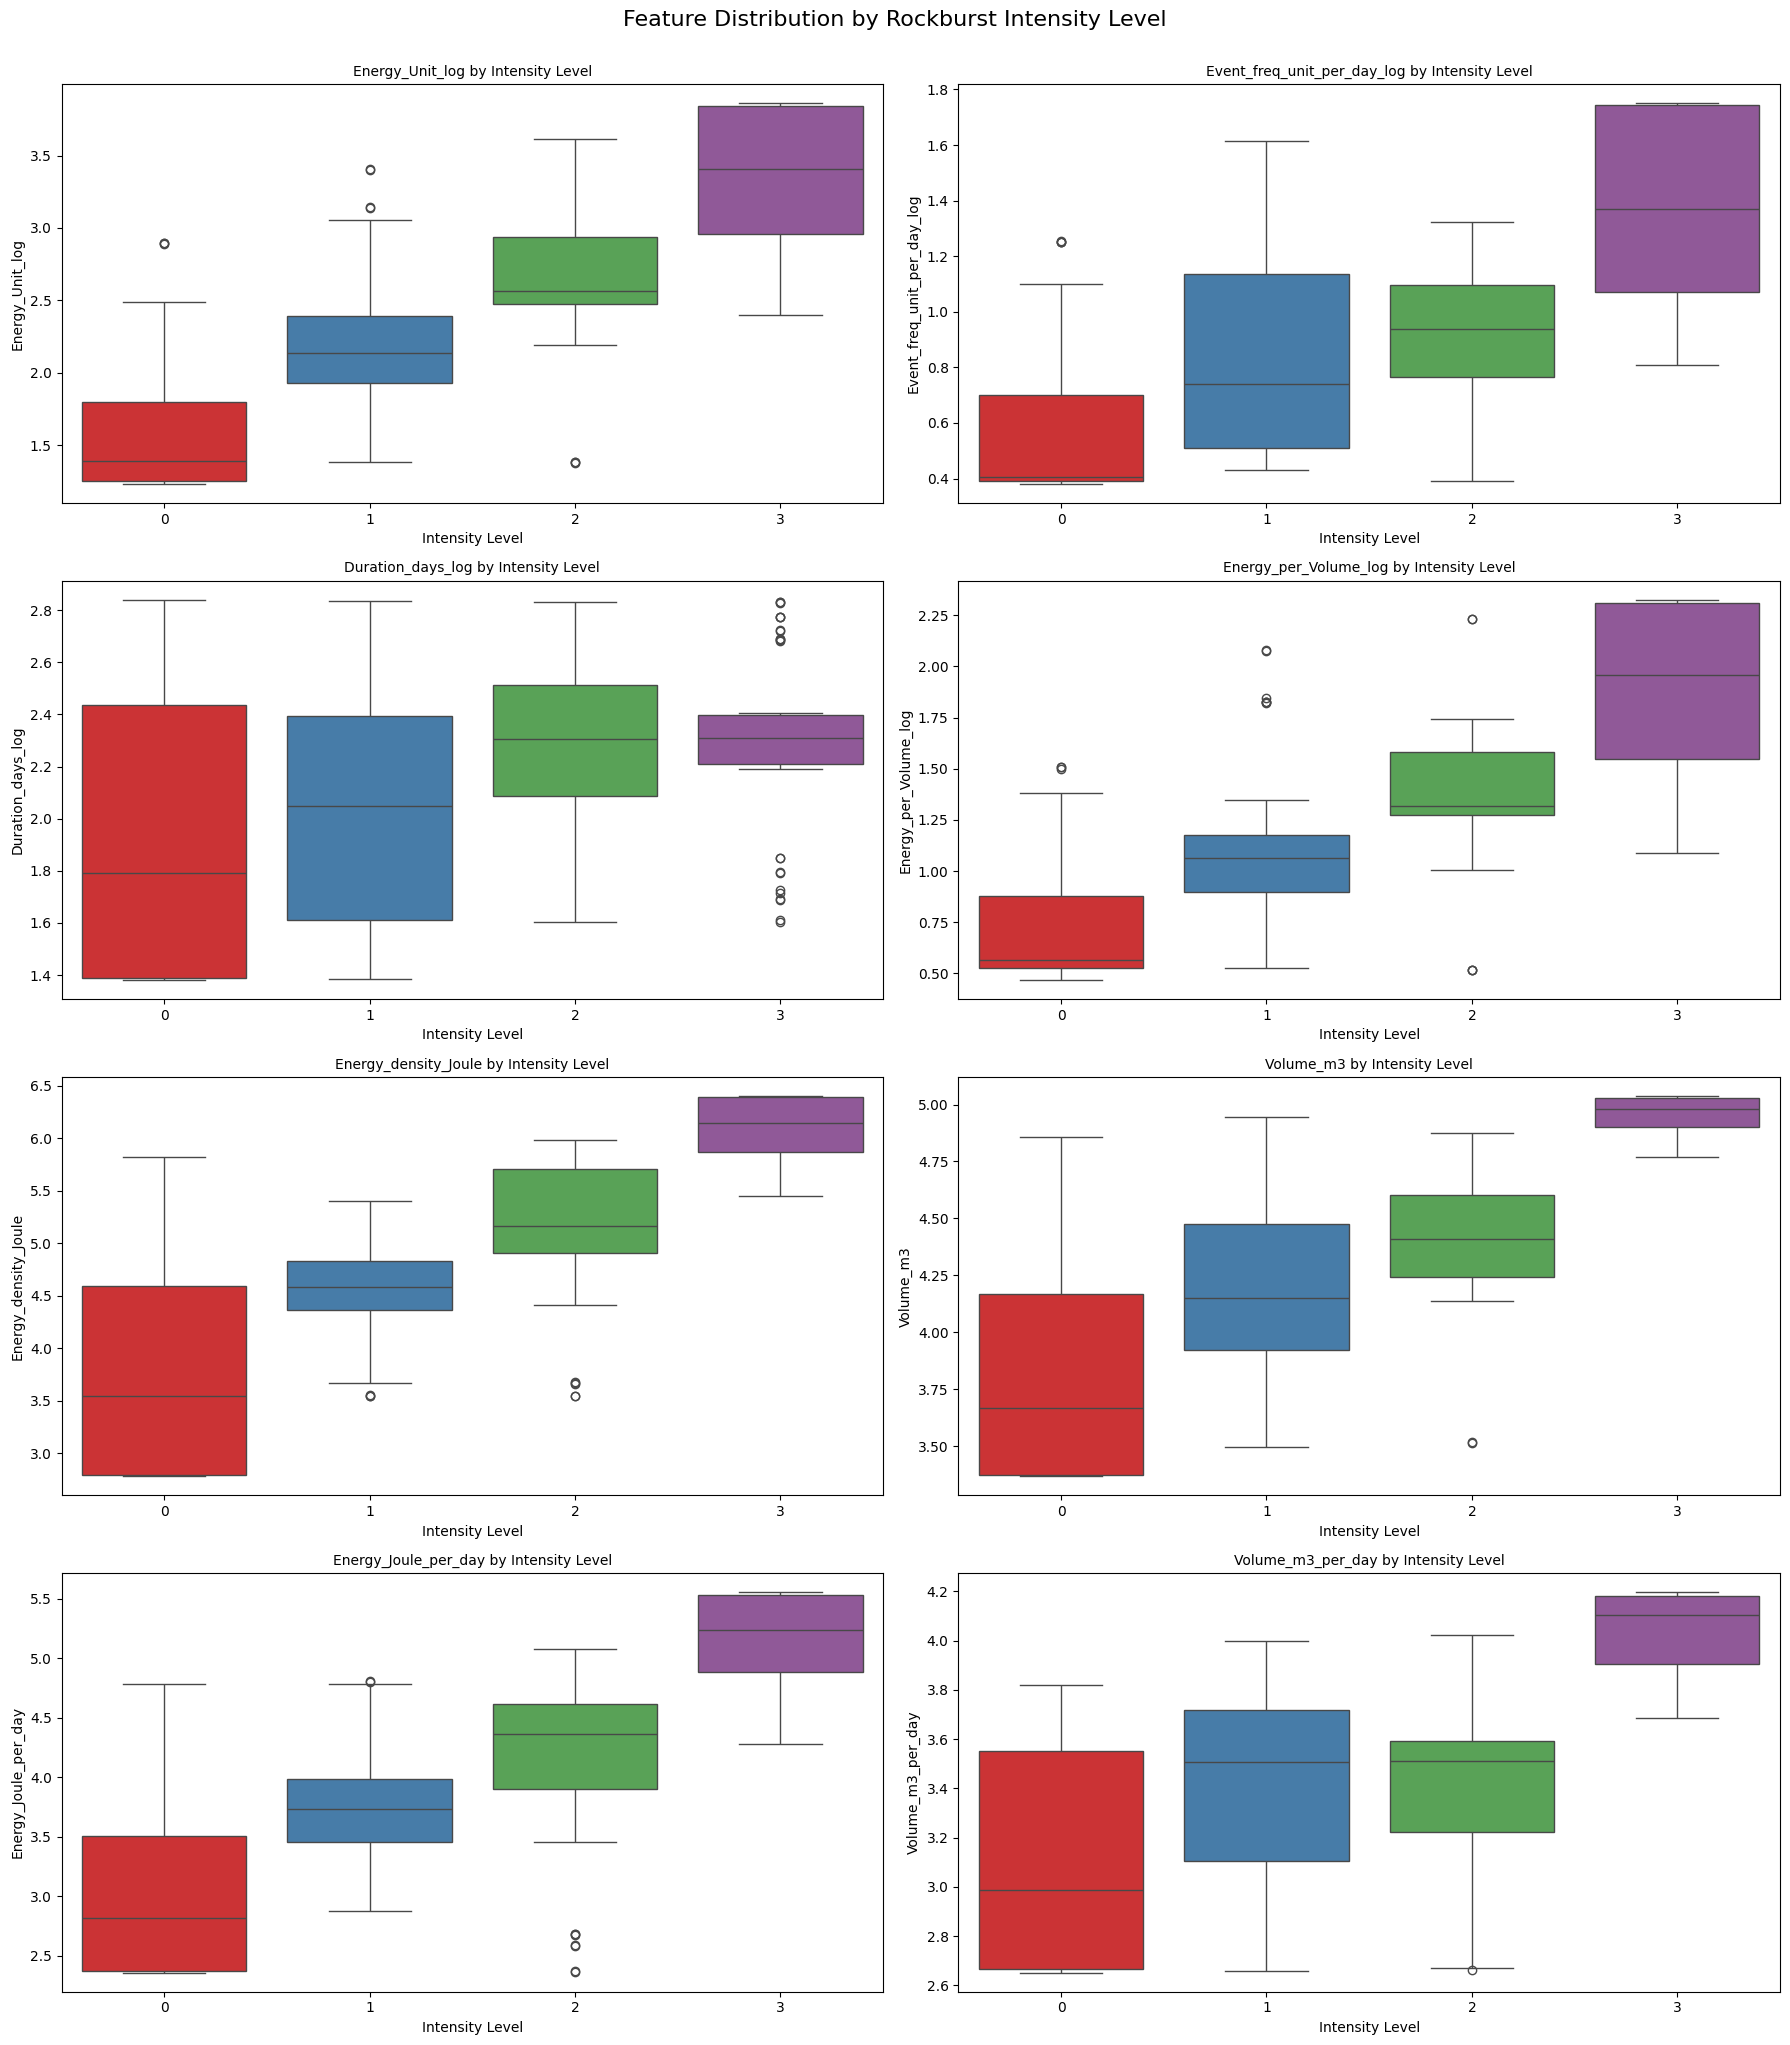

In [132]:
features = [col for col in df.columns if col not in ['Intensity_Level_encoded']]
n_features = len(features)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Intensity_Level_encoded', y=feature, data=df, palette='Set1', ax=axes[i],hue="Intensity_Level_encoded",legend=False)
    axes[i].set_title(f"{feature} by Intensity Level", fontsize=10)
    axes[i].set_xlabel("Intensity Level")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Feature Distribution by Rockburst Intensity Level", fontsize=16, y=1.02)
plt.show()

In [133]:
df.to_csv("Data/Preprocessed/Rockburst_in_Tunnel_V3.csv")

In [134]:
test_df=pd.concat([X_test,y_test],axis=1)

In [135]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 17 to 37
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Energy_Unit_log              19 non-null     float64
 1   Event_freq_unit_per_day_log  19 non-null     float64
 2   Duration_days_log            19 non-null     float64
 3   Energy_per_Volume_log        19 non-null     float64
 4   Energy_density_Joule         19 non-null     float64
 5   Volume_m3                    19 non-null     float64
 6   Energy_Joule_per_day         19 non-null     float64
 7   Volume_m3_per_day            19 non-null     float64
 8   Intensity_Level_encoded      19 non-null     int64  
dtypes: float64(8), int64(1)
memory usage: 1.5 KB


In [136]:
test_df.to_csv("Data/Preprocessed/Rockburst_test_data.csv",index=False)